In [1]:
import pandas as pd
import datetime
import numpy as np
from pandas.io.data import DataReader
import urllib2
import matplotlib.pyplot as plt

//anaconda/lib/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [2]:
start_date=datetime.datetime(2004,1,12)
end_date=datetime.datetime(2015,11,12)

In [3]:
NYSE_advn = pd.DataFrame.from_csv('data/NYSE_advn.csv', header=None, sep=',')
NYSE_decln = pd.DataFrame.from_csv('data/NYSE_decln.csv', header=None, sep=',')

In [4]:
spx = DataReader("^GSPC", "yahoo", start_date, end_date)

In [5]:
td = pd.DataFrame(index=spx.index)

In [6]:
td["Today"]=spx["Adj Close"]

In [7]:
td["NYSE_advn"] = NYSE_advn[1][start_date:end_date]
td["NYSE_decln"] = NYSE_decln[1][start_date:end_date]

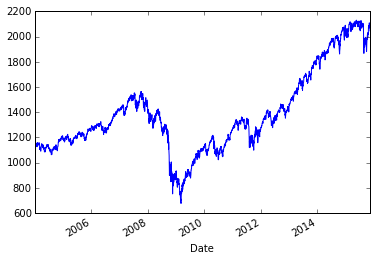

In [8]:
from matplotlib.dates import  DateFormatter, WeekdayLocator, HourLocator, DayLocator, MONDAY
from matplotlib.finance import candlestick_ochl
import matplotlib.dates as mdates
%matplotlib inline
td["Today"].plot()

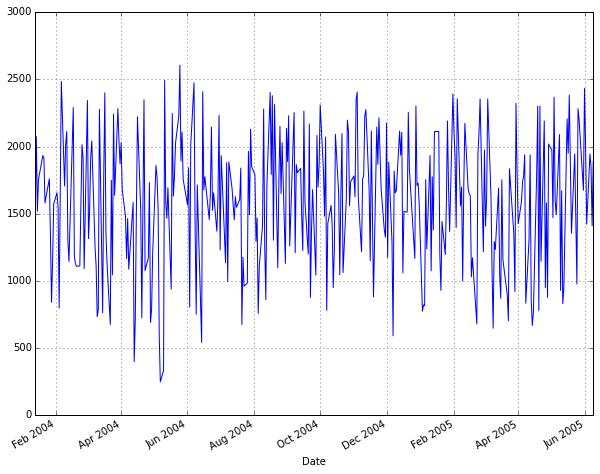

In [9]:
td["NYSE_advn"][1:356].plot(grid=True, figsize=(10,8))

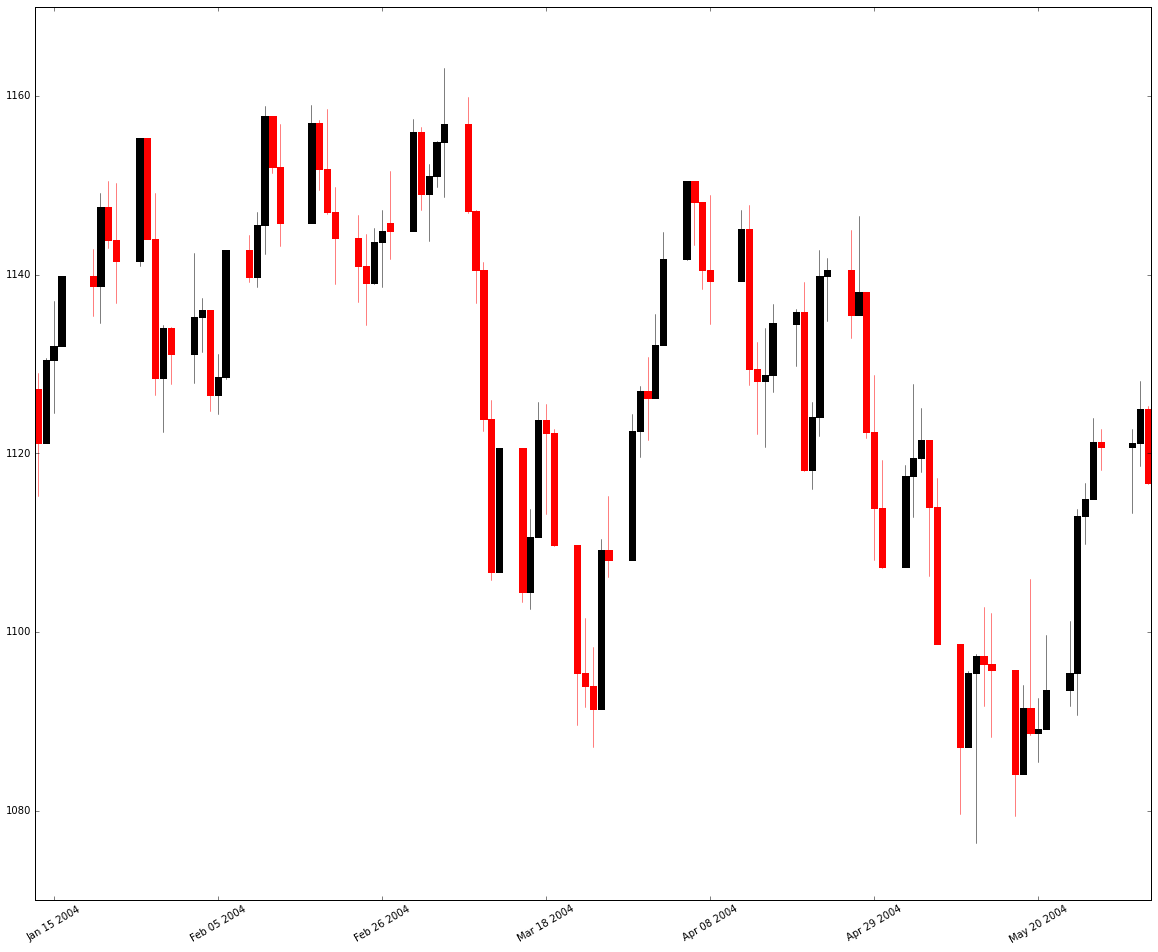

In [10]:
spx["mDate"] = mdates.date2num(spx.index.to_pydatetime())
datarec=[tuple(x) for x in spx[["mDate","Open","Close","High","Low"]].to_records(index=False)]
fig = plt.figure(figsize=(20,16))
ax1 = plt.subplot(1,1,1)
candlestick_ochl(ax1, datarec[1:100], width=0.8)
ax1.xaxis_date()
ax1.autoscale_view()
plt.setp(ax1.get_xticklabels(), rotation=30)
plt.show()

In [11]:
#Calculate McClellan Oscillator
RANA = (1000.0*(NYSE_advn-NYSE_decln)/(NYSE_advn+NYSE_decln))
RANA = RANA.apply(np.round)


In [12]:
#EMA19 calculation
def ema(data, window):
    c = 2.0 / (window + 1)
    current_ema = 0
    result_ema = []
    for value in data.itertuples():
        current_ema = (c * value[1]) + ((1 - c) * current_ema)
        result_ema.append(current_ema)
    data_ema = pd.DataFrame(result_ema, index=data.index)
    return data_ema


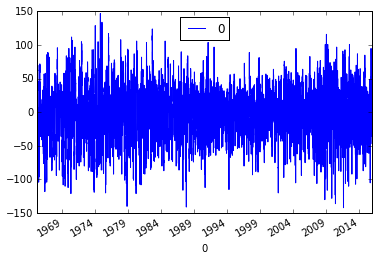

In [13]:
NYMO = ema(RANA, 19) - ema(RANA, 39)
NYMO = NYMO.apply(np.round)
NYMO.plot()


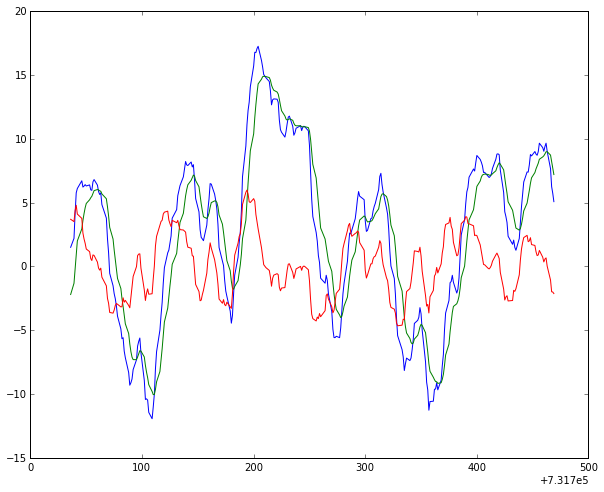

In [14]:
#calculate MACD
MACD = ema(spx, 12) - ema(spx, 26)
MACD_signal = ema(MACD, 9)
MACD_hist = MACD-MACD_signal
dates = mdates.date2num(MACD.index.to_pydatetime())
fig, ax=plt.subplots(figsize=(10,8))
plt.plot(dates[100:400],MACD[100:400])
plt.plot(dates[100:400],MACD_signal[100:400])
plt.plot(dates[100:400],MACD_hist[100:400])




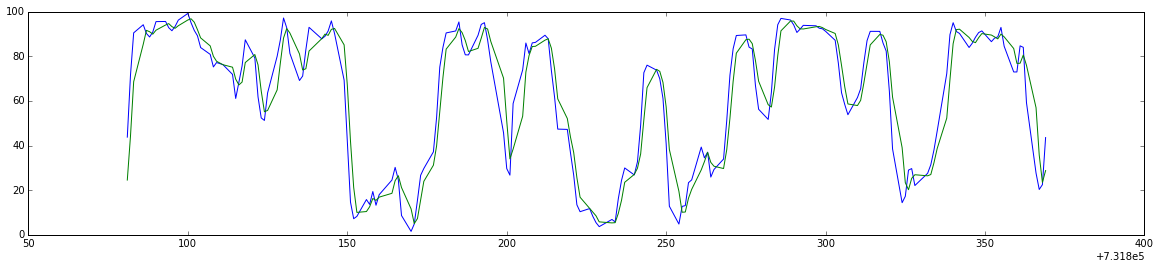

In [15]:
#calcuate slow STO
LookBack = 14
DailyHigh = pd.DataFrame()
for i in xrange(0,LookBack):
    DailyHigh["high%s" % str(i)] = spx["High"].shift(i)
Highest = DailyHigh.max(axis=1)
DailyLow = pd.DataFrame()
for i in xrange(0,LookBack):
    DailyLow["low%s" % str(i)] = spx["Low"].shift(i)
Lowest = DailyLow.min(axis=1)
STO = 100*(spx["Close"]-Lowest)/(Highest-Lowest)
slow_sto_K = pd.rolling_mean(STO,3)
slow_sto_D = pd.rolling_mean(slow_sto_K,3)

dates = mdates.date2num(slow_sto_D.index.to_pydatetime())
fig, ax=plt.subplots(figsize=(20,4))
plt.plot(dates[200:400],slow_sto_K[200:400])
plt.plot(dates[200:400],slow_sto_D[200:400])


In [16]:
out = pd.DataFrame(index=spx.index)
out['Buy'] = 0
out['Sell'] = 0
out['Sell'][datetime.datetime(2015,11,3)]=1
out['Buy'][datetime.datetime(2015,9,28)]=1

In [17]:
def get_google_data(symbol, period, window):
    url_root = 'http://www.google.com/finance/getprices?i='
    url_root += str(period) + '&p=' + str(window)
    url_root += 'd&f=d,o,h,l,c,v&df=cpct&q=' + symbol
    response = urllib2.urlopen(url_root)
    data = response.read().split('\n')
    #actual data starts at index = 7
    #first line contains full timestamp,
    #every other line is offset of period from timestamp
    parsed_data = []
    anchor_stamp = ''
    end = len(data)
    for i in range(7, end):
        cdata = data[i].split(',')
        if 'a' in cdata[0]:
            #first one record anchor timestamp
            anchor_stamp = cdata[0].replace('a', '')
            cts = int(anchor_stamp)
            parsed_data.append((datetime.datetime.fromtimestamp(float(cts)), float(cdata[1]), float(cdata[2]), float(cdata[3]), float(cdata[4]), float(cdata[5])))            
        else:
            try:
                coffset = int(cdata[0])
                cts = int(anchor_stamp) + (coffset * period)
                parsed_data.append((datetime.datetime.fromtimestamp(float(cts)), float(cdata[1]), float(cdata[2]), float(cdata[3]), float(cdata[4]), float(cdata[5])))
            except:
                pass # for time zone offsets thrown into data
    df = pd.DataFrame(parsed_data)
    df.columns = ['ts', 'o', 'h', 'l', 'c', 'v']
    df.index = df.ts
    del df['ts']
    return df


In [18]:
spy=get_google_data('SPY',60,15)
mf = (spy['o']-spy['c'])*spy['v']


In [19]:
sp500stocks = pd.DataFrame.from_csv('data/constituents.csv', sep=',')
sp500stocks

,Name,Sector
Symbol,,
MMM,3M Company,Industrials
ABT,Abbott Laboratories,Health Care
ABBV,AbbVie,Health Care
ACN,Accenture plc,Information Technology
ATVI,Activision Blizzard,Information Technology
ADBE,Adobe Systems Inc,Information Technology
ADT,ADT Corp,Industrials
AAP,Advance Auto Parts,Consumer Discretionary
AES,AES Corp,Utilities


In [22]:
count=0
for index, row in sp500stocks.iterrows():
    count=count+1
    print(count)
    indext=index.replace('-','.')
    print(indext)
    data=get_google_data(indext,60,15)
    mf = (data['o']-data['c'])*data['v']
    if count==1:
        mfall= mf
        mfall.columns=[indext]
    else:
        mfall[indext] = mf
        



    


1
MMM
2
ABT
3
ABBV
4
ACN
5
ATVI
6
ADBE
7
ADT
8
AAP
9
AES
10
AET
11
AMG
12
AFL
13
A
14
GAS
15
APD
16
ARG
17
AKAM
18
AA
19
ALXN
20
ALLE
21
AGN
22
ADS
23
ALL
24
GOOGL
25
GOOG
26
MO
27
AMZN
28
AEE
29
AAL
30
AEP
31
AXP
32
AIG
33
AMT
34
AMP
35
ABC
36
AME
37
AMGN
38
APH
39
APC
40
ADI
41
ANTM
42
AON
43
APA
44
AIV
45
AAPL
46
AMAT
47
ADM
48
AIZ
49
T
50
ADSK
51
ADP
52
AN
53
AZO
54
AVGO
55
AVB
56
AVY
57
BHI
58
BLL
59
BAC
60
BCR
61
BXLT
62
BAX
63
BBT
64
BDX
65
BBBY
66
BRK.B
67
BBY
68
BIIB
69
BLK
70
HRB
71
BA
72
BWA
73
BXP
74
BSX
75
BMY
76
BF.B
77
CHRW
78
CA
79
CVC
80
COG
81
CAM
82
CPB
83
COF
84
CAH
85
KMX
86
CCL
87
CAT
88
CBG
89
CBS
90
CELG
91
CNP
92
CTL
93
CERN
94
CF
95
SCHW
96
CHK
97
CVX
98
CMG
99
CB
100
CHD
101
CI
102
XEC
103
CINF
104
CTAS
105
CSCO
106
C
107
CFG
108
CTXS
109
CME
110
CMS
111
COH
112
CCE
113
CTSH
114
CL
115
CPGX
116
CMCSA
117
CMA
118
CAG
119
CXO
120
COP
121
CNX
122
ED
123
STZ
124
GLW
125
COST
126
CCI
127
CSRA
128
CSX
129
CMI
130
CVS
131
DHI
132
DHR
133
DRI
134
DVA
135
DE
136
DLPH
